Import Libraries

In [3]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25847 sha256=5e18e03d82e80173dc10fae73ec449da02a03b4c8ec79bbc2d5e3b507e97f4b6
  Stored in directory: c:\users\ahmad\appdata\local\pip\cache\wheels\4b\a5\2d\4a070a801d3a3d93f033d3ee9728f470f514826e89952df3ea
Successfully built imutils


In [4]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset,Dataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

link of the animals dataset 
https://drive.google.com/file/d/1wOMljDQMRgh3QjtnbOliyWtQFhH0mGn0/view?usp=share_link

#Class to load the dataset images from drive

In [6]:

class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

In [7]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

In [8]:
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader

In [26]:
print(len(image_paths))

3000


In [9]:
image_paths = list(paths.list_images("animals"))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (3000, 32, 32, 3) to (3000, 32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
X_train, X_test, y_train, y_test= train_test_split(data, labels, test_size=0.25, random_state=42)

[INFO]: Images loading....
[INFO]: Processed 500/3000
[INFO]: Processed 1000/3000
[INFO]: Processed 1500/3000
[INFO]: Processed 2000/3000
[INFO]: Processed 2500/3000
[INFO]: Processed 3000/3000
[INFO]: Features Matrix: 9000000.0MB


In [10]:
X_train.shape

(2250, 3072)

In [21]:
class class_dataset(Dataset):
    pass
# code here
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx])


In [22]:
class SimpleClassificationNet(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        y_hat = self.fc5(x)
        return y_hat


In [23]:
#Preparing PyTorch DataSets and DataLoaders

# Builds tensors from numpy arrays

# code here

# Builds dataset containing ALL data points

#     code here

# Builds a loader of each set
# code here

#Preparing PyTorch DataSets and DataLoaders

train_dataset = class_dataset(X_train, y_train)
val_dataset = class_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
#model, optimizer and loss
model = SimpleClassificationNet().to(device)
stateDict=model.state_dict()


lr = 0.001
#  define optimizor here
# define loss here
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [27]:
#batch wise training loop
epochs = 100
train_losses = []
val_losses = []
best_accuracy=0

for epoch in range(epochs):  #epochs loop

    all_Y_train_epoch=np.array([]).reshape(0,1)
    all_Yhat_train_epoch=np.array([]).reshape(0,1)
    all_train_losses_epoch=np.array([])

    for X_train, Y_train in train_loader:        #batch wise training on train set
        model.train()
        
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)

        #forward pass
        logits = model(X_train)
        
        #backward pass
        optimizer.zero_grad()
        loss = loss_fn(logits, Y_train)
        loss.backward()
        optimizer.step()
        
        #store metrics for all batches of current epoch 
        y_hat=F.softmax(logits,dim=-1)
        y_hat=y_hat.detach().cpu().numpy()
        y_hat=np.argmax(y_hat,axis=1)
        y_hat=y_hat.reshape(-1,1)

        Y_train=Y_train.detach().cpu().numpy()
        Y_train=Y_train.reshape(-1,1)
        all_Y_train_epoch=np.vstack((all_Y_train_epoch,Y_train))
        all_Yhat_train_epoch=np.vstack((all_Yhat_train_epoch,y_hat))   
        all_train_losses_epoch=np.append(all_train_losses_epoch,loss.item())     
        
    
    
    #computing metrics for current epoch
    train_losses.append(all_train_losses_epoch.mean()) #mean loss for all batches    
    acTrain=accuracy_score(all_Y_train_epoch, all_Yhat_train_epoch)
    cmTrain=confusion_matrix(all_Y_train_epoch, all_Yhat_train_epoch)
    print(cmTrain)

    #validation loop also batch wise
    all_Y_val_epoch=np.array([]).reshape(0,1)
    all_Yhat_val_epoch=np.array([]).reshape(0,1)
    all_val_losses_epoch=np.array([])
    for X_val, Y_val in val_loader:  #batch wise validation set predictions only
        model.eval()
        
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        
        with torch.no_grad():            
            logits = model(X_val)           
            loss = loss_fn(logits, Y_val)
        
        #store metrics for all batches of current epoch 
        y_hat_val=F.softmax(logits,dim=-1)
        y_hat_val=y_hat_val.detach().cpu().numpy()
        y_hat_val=np.argmax(y_hat_val,axis=1)
        y_hat_val=y_hat_val.reshape(-1,1)
        Y_val=Y_val.detach().cpu().numpy()
        Y_val=Y_val.reshape(-1,1)
        all_Y_val_epoch=np.vstack((all_Y_val_epoch,Y_val))
        all_Yhat_val_epoch=np.vstack((all_Yhat_val_epoch,y_hat_val))   
        all_val_losses_epoch=np.append(all_val_losses_epoch,loss.item())     
            

    #computing metrics for current epoch
    val_losses.append(all_val_losses_epoch.mean()) #mean loss for all batches    
    acVal=accuracy_score(all_Y_val_epoch, all_Yhat_val_epoch)
    cmVal=confusion_matrix(all_Y_val_epoch, all_Yhat_val_epoch)
    
    print(f"epoch= {epoch}, accuracyTrain= {acTrain}, accuracyVal= {acVal}, train_loss= {train_losses[epoch]}, validation_loss= {val_losses[epoch]}")
    
    #checkpointing training
    if(acVal>best_accuracy):
        checkpoint = {'epoch': epoch,'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),'loss': train_losses,
                      'val_loss': val_losses}
        torch.save(checkpoint,'best.pth')



#loading best model
checkpoint = torch.load('best.pth')
# Restore state for model and optimizer
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
total_epochs = checkpoint['epoch']
losses = checkpoint['loss']
val_losses = checkpoint['val_loss']

[[265 305 168]
 [253 306 192]
 [174 209 378]]
epoch= 0, accuracyTrain= 0.42177777777777775, accuracyVal= 0.5386666666666666, train_loss= 4.791325925941199, validation_loss= 0.905632883310318
[[318 334  86]
 [294 340 117]
 [ 87 154 520]]
epoch= 1, accuracyTrain= 0.5235555555555556, accuracyVal= 0.5613333333333334, train_loss= 0.9385077541982624, validation_loss= 0.8595718642075857
[[402 271  65]
 [312 332 107]
 [ 88 131 542]]
epoch= 2, accuracyTrain= 0.5671111111111111, accuracyVal= 0.5413333333333333, train_loss= 0.8601696466056394, validation_loss= 0.872636745373408
[[401 277  60]
 [290 367  94]
 [ 71 143 547]]
epoch= 3, accuracyTrain= 0.5844444444444444, accuracyVal= 0.492, train_loss= 0.8336161316280634, validation_loss= 0.9317348375916481
[[395 282  61]
 [294 333 124]
 [ 77 128 556]]
epoch= 4, accuracyTrain= 0.5706666666666667, accuracyVal= 0.49333333333333335, train_loss= 0.8356971278996534, validation_loss= 0.905078815917174
[[387 293  58]
 [266 378 107]
 [ 57 129 575]]
epoch= 5,

[[523 193  22]
 [196 510  45]
 [ 26  33 702]]
epoch= 44, accuracyTrain= 0.7711111111111111, accuracyVal= 0.552, train_loss= 0.5050605661432508, validation_loss= 1.164910800755024
[[468 254  16]
 [201 514  36]
 [ 26  47 688]]
epoch= 45, accuracyTrain= 0.7422222222222222, accuracyVal= 0.5573333333333333, train_loss= 0.5379424472929726, validation_loss= 1.109757165114085
[[504 213  21]
 [202 503  46]
 [ 49  59 653]]
epoch= 46, accuracyTrain= 0.7377777777777778, accuracyVal= 0.5733333333333334, train_loss= 0.5567291349592344, validation_loss= 1.0757961943745613
[[537 170  31]
 [204 506  41]
 [ 36  49 676]]
epoch= 47, accuracyTrain= 0.764, accuracyVal= 0.5626666666666666, train_loss= 0.5094881280207298, validation_loss= 1.2388753568132718
[[504 216  18]
 [199 512  40]
 [ 27  38 696]]
epoch= 48, accuracyTrain= 0.7608888888888888, accuracyVal= 0.5653333333333334, train_loss= 0.48887975157146724, validation_loss= 1.1730415696899097
[[518 205  15]
 [183 527  41]
 [ 16  49 696]]
epoch= 49, accur

[[565 153  20]
 [125 581  45]
 [ 18  79 664]]
epoch= 88, accuracyTrain= 0.8044444444444444, accuracyVal= 0.56, train_loss= 0.46451750880395865, validation_loss= 1.1756088162461917
[[506 199  33]
 [131 546  74]
 [ 44  86 631]]
epoch= 89, accuracyTrain= 0.748, accuracyVal= 0.5386666666666666, train_loss= 0.5986550311807176, validation_loss= 1.0169057125846546
[[589 135  14]
 [131 582  38]
 [ 33  51 677]]
epoch= 90, accuracyTrain= 0.8213333333333334, accuracyVal= 0.5733333333333334, train_loss= 0.4191375408374088, validation_loss= 1.4989687303702037
[[571 153  14]
 [109 612  30]
 [ 11  41 709]]
epoch= 91, accuracyTrain= 0.8408888888888889, accuracyVal= 0.576, train_loss= 0.371522016298603, validation_loss= 1.6462096472581227
[[598 124  16]
 [ 90 635  26]
 [ 10  36 715]]
epoch= 92, accuracyTrain= 0.8657777777777778, accuracyVal= 0.5493333333333333, train_loss= 0.3422741269771482, validation_loss= 1.4041235620776813
[[558 167  13]
 [ 98 621  32]
 [ 10  42 709]]
epoch= 93, accuracyTrain= 0.8

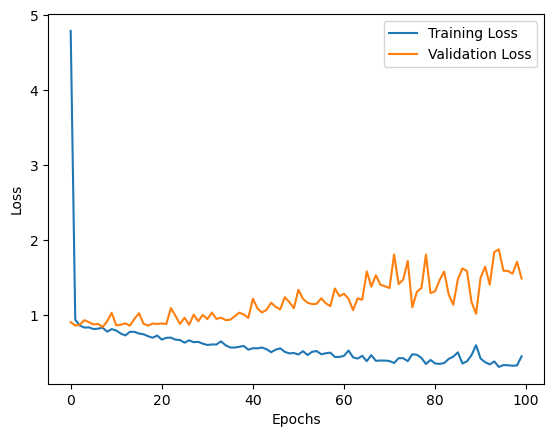

In [28]:
# plot the losses here
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()